# Exercise 2.1: Named entity recognition

In this exercise, we will implement a named entity recognition system using a few different neural models. This example uses training and validation data from the [CoNLL-2003 Shared Task](https://www.clips.uantwerpen.be/conll2003/ner/).

In [1]:
import torch
from torch import nn
import time
import numpy as np

import random
from torch.utils.data import DataLoader
from collections import defaultdict, Counter

import matplotlib.pyplot as plt

To make this notebook less cluttered, we move some utilities for preprocessing, batch management, and evaluation into a separate Python file `ner_util.py`.

The main utilities in this file are:
* `read_data` for reading the dataset,
* `Vocabulary` for managing the vocabulary,
* `SequenceDataset` and `SequenceBatcher` for managing minibatches,
* `load_gensim_vectors` for loading pre-trained word embeddings via [gensim](https://radimrehurek.com/gensim/),
* `evaluate_bio` for computing evaluation scores for the predicted entities,
* `show_entities` for printing sentences and their entities in a nice format.

In [2]:
import ner_util

## The data

The training, validation and testing data can be downloaded from the following site:

http://demo.spraakdata.gu.se/richard/dl4nlp/ex2_1/

The username and password are both `waspnlp`.

A quick note about the format. The dataset consists of tokenized sentences. Each row corresponds to one token, and for each token there is a word a number of annotations, separated by whitespace. The sentences are separated by empty lines. Here is an example of a sentence.
```
United   NNP B-NP B-ORG
Nations  NNP I-NP I-ORG
official NN  I-NP O
Ekeus    NNP B-NP B-PER
heads    VBZ B-VP O
for      IN  B-PP O
Baghdad  NNP B-NP B-LOC
.        .   O    O
```
In this exercise, we will just use the first and last columns: the words and the BIO-coded named entity labels. (The second and third columns contain part-of-speech tags and phrase labels, but we will ignore them.)

The utility function `read_data` reads a file and returns the words and BIO labels for all sentences in a file.


## Step 0. Getting started with a baseline model for sequence labeling

We first define the neural network model.

Our first model is simplistic and will be extended later. To predict the output BIO tag for a word, this model applies an embedding and an output unit and it does not consider the context of the word. As we have seen in one of the lectures, this is likely to work quite poorly since words may behave differently in different contexts.

In [3]:
class SimpleSequenceModel(nn.Module):
    
    def __init__(self, word_emb_layer, n_labels):
        super().__init__()                

        # The model consists of just a word embedding layer and a
        # linear output unit. The embedding layer has already been created elsewhere.        
        self.word_embedding = word_emb_layer
        
        word_emb_dim = word_emb_layer.weight.shape[1]
        
        self.top_layer = nn.Linear(word_emb_dim, n_labels)
                        
    def forward(self, words):
        # words is a tensor of integer-encoded words, with shape (n_sentences, n_words)
                
        # After embedding the words, the shape is (n_sentences, n_words, emb_dim). 
        word_repr = self.word_embedding(words)
            
        # We predict the BIO label simply by applying a linear model to
        # the word embedding at that position.
        
        # The shape of the output is (n_sentences, n_words, n_labels),
        # where n_labels is the size of the output label vocabulary.
        return self.top_layer(word_repr)


### Building the complete the system

We can now assemble all the pieces and build a complete named entity recognition system, implemented in the class `SequenceLabeler`. 

The interesting part here is the method `train`, which carries out the preprocessing steps, sets up the neural network defined above, and then runs the training loop. You should be familiar with the general structure of this kind of programs by now. The comments inside the code explain the details more explicitly.

The method `predict` can be used to apply the trained NER system to new sentences.

The hyperparameters are stored in a container `SeqLabelerParameters`.

In [118]:
class SeqLabelerParameters:
    device = 'cuda'
    
    random_seed = 0
    
    train_file = '../data/eng.train.iob'
    valid_file = '../data/eng.valid.iob'
    
    use_characters = True
    
    word_emb_dim = 128
    
    pretrained_word_emb = gensim_glove_model
    finetune_word_emb = False
    
    n_epochs = 20
    batch_size = 128
    
    learning_rate = 5e-3
    weight_decay = 1e-6
    
    word_dropout_prob = 0.1
    

class SequenceLabeler:
    
    def __init__(self, params):
        self.params = params        
                
    def train(self):
        
        p = self.params
        
        # Setting a fixed seed for reproducibility.
        torch.manual_seed(p.random_seed)
        random.seed(p.random_seed)
        
        # Read training and validation data according to the predefined split.
        Xtrain, Ytrain = ner_util.read_data(p.train_file)
        Xval, Yval = ner_util.read_data(p.valid_file)
                
        # Create vocabularies for words and output labels.
        self.word_voc = ner_util.Vocabulary(include_unknown=True, gensim_model=p.pretrained_word_emb)
        self.label_voc = ner_util.Vocabulary(include_unknown=False)
        self.label_voc.build(Ytrain)
        
        # If we are using a pre-trained word embedding model, then we use its built-in vocabulary;
        # otherwise, we build the word vocabulary from the data.
        if not p.pretrained_word_emb:
            self.word_voc.build(Xtrain)        

        # Also create a vocabulary for characters. (Will be used in a later part of the exercise.)
        self.char_voc = ner_util.Vocabulary(include_unknown=True, character=True)            
        self.char_voc.build(Xtrain)
        
        # Put the training and validation data into Datasets and DataLoaders for managing minibatches.
        self.batcher = ner_util.SequenceBatcher(p.device)        
        train_dataset = ner_util.SequenceDataset(self.word_voc.encode(Xtrain),                                        
                                        self.label_voc.encode(Ytrain),
                                        self.char_voc.encode(Xtrain) if p.use_characters else None,
                                        word_dropout_prob=p.word_dropout_prob, 
                                        word_dropout_id=self.word_voc.get_unknown_idx())
        train_loader = DataLoader(train_dataset, p.batch_size, shuffle=True, collate_fn=self.batcher)        
        val_dataset = ner_util.SequenceDataset(self.word_voc.encode(Xval), 
                                      self.label_voc.encode(Yval),
                                      self.char_voc.encode(Xval) if p.use_characters else None)
        val_loader = DataLoader(val_dataset, p.batch_size, shuffle=False, collate_fn=self.batcher)
        
        
        # Now, let's build the model!

        # First, we create a word embedding layer. We use another utility function for that (in
        # the Vocabulary object). The reason we are doing it in this way is just to simplify our
        # work if we want to use pre-trained embeddings later on.
        # For now, this will just build a straightforward nn.Embedding and return it.
        emb_layer = self.word_voc.make_embedding_layer(finetune=p.finetune_word_emb, 
                                                       emb_dim=p.word_emb_dim)
    
        # Create the sequence labeling neural network defined above.
        #self.model = SimpleSequenceModel(emb_layer, n_labels=len(self.label_voc))
        #self.model = WindowSequenceModel(emb_layer, n_labels=len(self.label_voc))
        #self.model = RNNSequenceModel(emb_layer, n_labels=len(self.label_voc),
        #                              rnn_size=128, rnn_depth=1)
        self.model = RNNCharSequenceModel(emb_layer, n_labels=len(self.label_voc),
                                          rnn_size=128, rnn_depth=1,
                                          char_emb_dim=16, char_voc_size=len(self.char_voc))
        
        self.model.to(p.device)
        optimizer = torch.optim.Adam(self.model.parameters(), 
                                     lr=p.learning_rate, weight_decay=p.weight_decay)

        # Cross-entropy loss function that we will use to optimize the model.
        # In particular, note that by using ignore_index, we will not compute the loss 
        # for the positions where we have a padding token.
        loss_func = torch.nn.CrossEntropyLoss(ignore_index=self.label_voc.get_pad_idx())
        
        history = defaultdict(list)
                            
        for i in range(p.n_epochs):

            t0 = time.time()

            loss_sum = 0

            self.model.train()
            for Xbatch_words, Ybatch, Xbatch_chars in train_loader:
                                                
                # Compute the output scores.
                scores = self.model(Xbatch_words, Xbatch_chars)
                
                # The scores tensor has the shape (n_sentences, n_words, n_labels).
                # We reshape this to (n_sentences*n_words, n_labels) because the loss requires
                # a 2-dimensional tensor. Similar for the gold standard label tensor.                
                loss = loss_func(scores.view(-1, len(self.label_voc)), Ybatch.view(-1))
                    
                optimizer.zero_grad()            
                loss.backward()
                optimizer.step()
                loss_sum += loss.item()

            train_loss = loss_sum / len(train_loader)
            history['train_loss'].append(train_loss)
            
            # Evaluate on the validation set.
            stats = defaultdict(Counter)

            self.model.eval()
            with torch.no_grad():
                for Xbatch_words, Ybatch, Xbatch_chars in val_loader:
                    scores = self.model(Xbatch_words, Xbatch_chars)
                    
                    # Compute the highest-scoring labels at each word position.
                    predicted = scores.argmax(dim=2)
                    
                    # Update the evaluation statistics for this batch.
                    ner_util.evaluate_iob(Xbatch_words, predicted, Ybatch, self.label_voc, stats)

            # Compute the overall F-score for the validation set.
            _, _, val_f1 = ner_util.prf(stats['total'])

            history['val_f1'].append(val_f1)

            t1 = time.time()
            print(f'Epoch {i+1}: train loss = {train_loss:.4f}, val f1: {val_f1:.4f}, time = {t1-t0:.4f}')
           
        # After the final evaluation, we print more detailed evaluation statistics, including
        # precision, recall, and F-scores for the different types of named entities.
        print()
        print('Final evaluation on the validation set:')
        p, r, f1 = ner_util.prf(stats['total'])
        print(f'Overall: P = {p:.4f}, R = {r:.4f}, F1 = {f1:.4f}')
        for label in stats:
            if label != 'total':
                p, r, f1 = ner_util.prf(stats[label])
                print(f'{label:4s}: P = {p:.4f}, R = {r:.4f}, F1 = {f1:.4f}')
        
        self.stats = stats
        
        plt.plot(history['train_loss'])
        plt.plot(history['val_f1'])
        plt.legend(['training loss', 'validation F-score'])

        
    def predict(self, sentences):
        # This method applies the trained model to a list of sentences.
        
        Ydummy = [[self.label_voc.itos[0]]*len(sen) for sen in sentences]
            
        dataset = ner_util.SequenceDataset(self.word_voc.encode(sentences), 
                                  self.label_voc.encode(Ydummy),
                                  self.char_voc.encode(sentences))
        loader = DataLoader(dataset, self.params.batch_size, shuffle=False, collate_fn=self.batcher)
                
        out = []
        self.model.eval()
        with torch.no_grad():
            for Xbatch_words, _, Xbatch_chars in loader:
                
                scores = self.model(Xbatch_words, Xbatch_chars)                   
                predicted = scores.argmax(dim=2) 
                
                # Convert the integer-encoded tags to tag strings.
                for pred_sen in predicted.cpu().numpy():
                    tokens = sentences[len(out)]
                    out.append([self.label_voc.itos[pred_id] for _, pred_id in zip(tokens, pred_sen[1:])])
        return out

We can now train the complete system. The training loop will compute the loss during each epoch, and then compute the F-score (the harmonic mean of precision and recall) on the validation set.

After completing the training process, we get some more detailed evaluation results, where you can see precision, recall, and F-scores for all types of entities. After 10 epochs with the default system, we get an F-score of about 0.60, so the system has learned to pick up some named entities although it is far from perfect.

Epoch 1: train loss = 0.2716, val f1: 0.8414, time = 4.0089
Epoch 2: train loss = 0.0791, val f1: 0.8767, time = 4.2544
Epoch 3: train loss = 0.0615, val f1: 0.9012, time = 3.9761
Epoch 4: train loss = 0.0508, val f1: 0.9041, time = 3.9798
Epoch 5: train loss = 0.0416, val f1: 0.9166, time = 3.7183
Epoch 6: train loss = 0.0337, val f1: 0.9146, time = 4.0349
Epoch 7: train loss = 0.0301, val f1: 0.9142, time = 4.0020
Epoch 8: train loss = 0.0272, val f1: 0.9172, time = 4.0083
Epoch 9: train loss = 0.0229, val f1: 0.9138, time = 3.9902
Epoch 10: train loss = 0.0213, val f1: 0.9114, time = 4.0286
Epoch 11: train loss = 0.0191, val f1: 0.9190, time = 4.0283
Epoch 12: train loss = 0.0164, val f1: 0.9198, time = 3.9831
Epoch 13: train loss = 0.0156, val f1: 0.9201, time = 4.0151
Epoch 14: train loss = 0.0152, val f1: 0.9168, time = 4.0092
Epoch 15: train loss = 0.0149, val f1: 0.9175, time = 4.0405
Epoch 16: train loss = 0.0180, val f1: 0.9197, time = 4.0331
Epoch 17: train loss = 0.0123, va

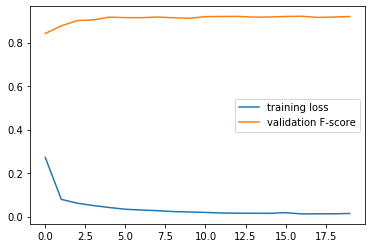

In [122]:
ner_system = SequenceLabeler(SeqLabelerParameters())
ner_system.train()

### Trying out some examples

Let's consider some examples and try to understand how the system behaves.

As mentioned above, we can call `predict` to get the system's predictions for a new text. The text needs to be split into sentences and tokens. The corresponding BIO labels will be returned.

In [25]:
ner_system.predict(['Jane lives in New York City .'.split()])

[['B-PER', 'O', 'O', 'B-LOC', 'I-LOC', 'I-LOC', 'O']]

There is also a utility function `show_entities` that shows the sentence and the entities in a colored format.

In [42]:
ner_util.show_entities(ner_system, ['Jane lives in New York City .'.split()])

It gets more interesting when we include some words that should be tagged differently depending on the context. Here, we can clearly see the limitations of our current model. (In the second example, we'd like *Manchester* to be an organization in the first case and a location in the second case.)

In [43]:
ner_util.show_entities(ner_system, ['Manchester United will return to the United States .'.split(),
                                    'Manchester scored against Liverpool when they were playing in Manchester .'.split()])

We can also note that the system generalizes poorly when we encounter words that have not been observed in the training set. Our system does not find any names in the example below, but as human readers, we don't have a problem to understand that *Tarakanov* is a person and *Lüneburg* is a location.

For instance, we might already know from prior experience that *Tarakanov* is a surname, or we can deduce this because of the *-ov* suffix or because the context makes it likely that this is a person. Similarly, we might have heard about *Lüneburg* (a city in Germany) before, or we guess that this is a place because of the context or the *-burg* suffix.

In [44]:
ner_util.show_entities(ner_system, ['Tarakanov lives in Lüneburg .'.split()])

## Step 1. Window-based sequence labeling

Our first model works poorly because it does not take the surrounding words into account when predicting the output labels. So let's simply build a second prediction model that not only looks at a single word in isolation, but also considers one word before and one word after.

<img src="http://www.cse.chalmers.se/~richajo/waspnlp2020/ex2_1/ffwin_simpler.svg" alt="Drawing" style="width: 200px;"/>

**Hint**: To save you some time in the exercise, here is some code that might be useful when you compute the representations of the three-word windows. We assume that we have computed a word embedding tensor `word_repr` for our batch as in the code above, which will then have the shape `(n_sentences, n_words, emb_dim)`.

We can then create a tensor `before_word_repr` that contains word embeddings shifted one step backward, and another tensor `after_word_repr` where the embeddings have been shifted one step forward. We insert some zero padding so that these tensors will have the same shape as `word_repr`.

    n_sent, _, emb_dim = word_repr.shape
    zero_pad = torch.zeros(n_sent, 1, emb_dim, device=word_reps.device)
    word_before_repr = torch.cat([zero_pad, word_repr[:,:-1,:]], dim=1)
    word_after_repr = torch.cat([word_repr[:,1:,:], zero_pad], dim=1)

Then "glue" the three word embedding tensors together using `torch.cat` so that you get a tensor representing the 3-word windows. This will then have the shape `(n_sentences, n_words, 3*emb_dim)`.

Finally, modify the output unit to reflect this change and rerun the code. Do the scores improve? How about the test cases above?

### *** Solution ***

My validation F-score is 0.7947, up from 0.64. `n_epochs` was increased to 20, all other hyperparameters unchanged.

In [14]:
class WindowSequenceModel(nn.Module):
    
    def __init__(self, word_emb_layer, n_labels):
        super().__init__()                
        self.word_embedding = word_emb_layer
        word_emb_dim = word_emb_layer.weight.shape[1]
        self.top_layer = nn.Linear(3*word_emb_dim, n_labels)
                        
    def forward(self, words):
        word_repr = self.word_embedding(words)
        
        n_sent, _, emb_dim = word_repr.shape
        zero_pad = torch.zeros(n_sent, 1, emb_dim, device=word_repr.device)
        word_before_repr = torch.cat([zero_pad, word_repr[:,:-1,:]], dim=1)
        word_after_repr = torch.cat([word_repr[:,1:,:], zero_pad], dim=1)
        
        # combine the 3 embedding tensors
        window_repr = torch.cat([word_before_repr, word_repr, word_after_repr], dim=2)
        
        return self.top_layer(window_repr)

With this we can improve some of the test cases above. The example with the unknown words still doesn't give anything.

In [29]:
ner_util.show_entities(ner_system, ['Manchester United will return to the United States .'.split(),
                                    'Manchester scored against Liverpool when they were playing in Manchester .'.split(),
                                    'Tarakanov lives in Lüneburg .'.split()])

## Step 2. RNN-based sequence labeling

The window-based prediction model is limited in its representation capabilities by the width of the window, so let's try to use a RNN-based representation, which does not have this limitation. The following figure gives you an idea of the type of model we should try to build: 

<img src="http://www.cse.chalmers.se/~richajo/waspnlp2020/ex2_1/rnn_seq_ner.svg" alt="Drawing" style="width: 600px;"/>

**Hint 1**: The code to build the model and the `forward` step will probably be quite similar to what you wrote in the language modeling exercise.

**Hint 2**: a bidirectional RNN will probably be more useful than the model in the figure. Any idea why?

### *** Solution ***

My validation F-score is 0.8420 with 15 epochs, and a bidirectional GRU of depth 1 and a size of 128. 

In [56]:
class RNNSequenceModel(nn.Module):
    
    def __init__(self, emb_layer, n_labels, rnn_size, rnn_depth):
        super().__init__()
        self.embedding = emb_layer
        word_dim = emb_layer.weight.shape[1]
        
        # RNN layer. We're using a bidirectional GRU.
        self.rnn = nn.GRU(batch_first=True, input_size=word_dim, hidden_size=rnn_size, 
                          bidirectional=True, num_layers=rnn_depth)
        #self.rnn = nn.LSTM(batch_first=True, input_size=word_dim, hidden_size=rnn_size, 
        #                   bidirectional=True, num_layers=1)

        # Output layer. The input size is two times
        # the RNN size since we are using a bidirectional RNN.
        self.top_layer = nn.Linear(2*rnn_size, n_labels)
              
            
    def forward(self, words):
        # input shape: (n_seqs, max_len)
        
        # shape: (n_seqs, max_len, emb_dim). 
        word_repr = self.embedding(words)
                        
        # shape: (n_seqs, max_len, 2*rnn_size)
        rnn_out, _ = self.rnn(word_repr)
        
        # output shape: (n_seqs, max_len, n_labels)
        return self.top_layer(rnn_out)


We still have a problem with unseen words. For the example above and those in the next section, we see that we can't find any names.

In [58]:
ner_util.show_entities(ner_system, ['Tarakanov lives in Lüneburg .'.split(),
                                    'Linköping is nice .'.split(),
                                    'Judy is nice'.split()])

## Step 3. Pre-trained word embeddings

How can we deal with names that we haven't seen before? For instance, in the following examples, the names are not present in the training set, and the context doesn't give us much information:

    Linköping is nice.
    Judy is nice.

Currently, since *Linköping* and *Judy* haven't been seen before, their representations will be identical, since we will use a generic "unknown word" embedding in these cases. Pre-trained word embeddings may help us here: while *Linköping* is not present in our training set, it is distributionally similar to names of other cities, and this might help us to assign the correct label `B-LOC`.

The [gensim](https://radimrehurek.com/gensim/) library includes a number of built-in word embedding models. You can find a list of them here:

https://github.com/RaRe-Technologies/gensim-data#models

The utility function `load_gensim_vectors` loads a pre-trained word embedding model and converts it into a PyTorch tensor. Gensim will automatically download the file (which will take some minutes the first time). For instance:

    gensim_glove_model = ner_util.load_gensim_vectors('glove-wiki-gigaword-100', builtin=True)

Here, `glove-wiki-gigaword-100` is the name of the model, and `builtin=True` shows that we are using one of the library's built-in models (and not a file of our own).

Load one of gensim's pre-trained models. Then, in the hyperparameter settings defined above, change `pretrained_word_emb = None` to the embedding model you loaded. Retrain the model and see if this improves the results. Can the system handle the problematic examples above now?

**Hint**: it might be useful to investigate whether the word embedding model should be *fine-tuned* or not. This can be controlled via the hyperparameter `finetune_word_emb`. 

### *** Solution: ***

The F-score is now 0.8839. Everything is identical to the previous RNN-based model, except that we're using the pre-trained model and that we disabled word embedding fine-tuning.

In [59]:
gensim_glove_model = ner_util.load_gensim_vectors('glove-wiki-gigaword-100', builtin=True)

Loading model 'glove-wiki-gigaword-100' via gensim... done!


Now we should be able to handle at least some of the previously unseen words. (In my solution, 3 out of four names in these examples are handled correctly.)

In [101]:
ner_util.show_entities(ner_system, ['Tarakanov lives in Lüneburg .'.split(),
                                    'Linköping is nice .'.split(),
                                    'Judy is nice'.split()])

## Step 4. Character-based word representation

Although we have improved the coverage by using the pre-trained word embeddings, the model still lacks a way to generalize in a way that takes word properties into account. For instance, as mentioned in the lecture, many Swedish surnames end in *-sson*, which could help us deduce that such strings are person names. Or on a more basic level, we may observe that an initial upper-case letter makes it more likely that a word is a name. By introducing a *character-based* word representation, our model might learn to generalize in this way.

The following figure gives you an idea of what we would like to implement:

<img src="http://www.cse.chalmers.se/~richajo/waspnlp2020/ex2_1/char_repr.svg" alt="Drawing" style="width: 400px;"/>

The "something" in this figure could be implemented in different ways:

* In [*Neural Architectures for Named Entity Recognition*](https://www.aclweb.org/anthology/N16-1030.pdf) by Lample et al. (2016), a bidirectional RNN is applied to the characters. (See Figure 4.)
* In [*End-to-end Sequence Labeling via Bi-directional LSTM-CNNs-CRF*](https://www.aclweb.org/anthology/P16-1101.pdf) by Ma and Hovy (2016), a convolutional layer and pooling is used. (See Figure 1.)

To work with characters in our code, first set the hyperparameter `use_characters` to `True`. By enabling this option, we will include character tensors in each minibatch. (That is, `Xbatch_chars` in the training loop will be non-empty.)

Then create a new model where the `forward` method takes the word and character tensors as the input, and implement a word representation approach that combines word embeddings with a character-based representation. Do you get better F-scores now? Also try to think of some test cases where it might be useful to take the word structure into account and investigate if your model can handle them better now than before.

**Hints**:
* RNN and CNN layers expect three-dimensional inputs. The character tensor in each batch has the shape `(n_sentences, n_words, n_characters)`, so you will likely have to reshape it into `(n_sentences*n_words, n_characters)` to get a 3-dimensional structure after embedding the characters.
* If you'd like to implement Lample's RNN-based architecture, you might have something like the following:
```
    _, (final_state, _) = char_rnn(character_embedding)  # if char_rnn is an LSTM
    _, final_state      = char_rnn(character_embedding)  # if char_rnn is a GRU
``` 
  In this case, `final_state` will be a tensor with the shape `(n_layers, batch_size, rnn_size)`. It contains the final RNN states in each layer for every sequence in the batch. To follow Lample's approach, you can extract the last two "rows" in this tensor.
* For a CNN-based solution as in Ma's architecture, you should use a one-dimensional convolution (`nn.Conv1d`) followed by a pooling operation. Note that the convolution is computed over the last dimension of the tensor, so you might need to transpose the tensor to put the character dimension last: `character_embedding.transpose(1, 2)`. To carry out a pooling operation over the entire sequence, you can use *adaptive* pooling layers, e.g. `nn.AdaptiveMaxPool1d(1)`.

### *** Solution ***

I tried out 3 different solutions (implementations below). The performance scores of these models seem to be more or less equivalent and they all reach F-scores of around 0.92.

With the Lample-like RNN-based representation, my F-score is 0.9193. The hyperparameters are the same as previously, except that `n_epochs` was set to 20 and the word dropout rate set to 0.1. The character embedding size (and character RNN size) was set to 16.

With this implementation, we can find all the names in the tricky test cases we tried previously.

In [121]:
ner_util.show_entities(ner_system, ['Tarakanov lives in Lüneburg .'.split(),
                                    'Linköping is nice .'.split(),
                                    'Judy is nice'.split()])

### *** RNN-based solution ***

Similar to Lample et al. (2016).

In [76]:
class RNNCharSequenceModel(nn.Module):
    
    def __init__(self, emb_layer, n_labels, rnn_size, rnn_depth, char_voc_size, char_emb_dim):
        super().__init__()
                
        self.embedding = emb_layer
        
        word_dim = emb_layer.weight.shape[1]

        # Character embedding.
        self.char_embedding = nn.Embedding(char_voc_size, char_emb_dim)
        
        # Character RNN. It's bidirectional with 1 layer as in Lample's paper.
        self.char_rnn = nn.GRU(input_size=char_emb_dim, hidden_size=char_emb_dim, batch_first=True,
                               bidirectional=True, num_layers=1)
        word_dim += 2*char_emb_dim
        
        self.rnn = nn.GRU(batch_first=True, input_size=word_dim, hidden_size=rnn_size, 
                          bidirectional=True, num_layers=rnn_depth)
        self.top_layer = nn.Linear(2*rnn_size, n_labels)
              
            
    def forward(self, words, chars):
        n_sent, n_words, n_chars = chars.shape
        
        # The shape of the embedded word tensor is (n_sent, n_words, emb_dim). 
        word_repr = self.embedding(words)
            
        # Reshape the character tensor so that we get a 3-dimensional tensor after embedding.
        chars = chars.view(n_sent*n_words, n_chars)

        # Look up character embeddings. The shape is now 
        # (n_sent*n_words, n_chars, char_emb_dim).        
        char_emb = self.char_embedding(chars)

        # Compute the final RNN states. This tensor has the 
        # shape (n_layers, n_sent*n_words, char_emb_dim).

        # If you use a GRU or simple RNN for the character RNN:
        _, final_state = self.char_rnn(char_emb)
        # if you use an LSTM for the character RNN:
        #_, (final_state, _) = self.char_rnn(char_emb)

        # Extract the final states from the highest forward and backward RNN layer.
        # Reshape these tensor to (n_sent, n_words, char_emb_dim).
        crnn_forward = final_state[-2].view(n_sent, n_words, -1)
        crnn_backward = final_state[-1].view(n_sent, n_words, -1)

        # Combine the word embeddings with character-based representations.
        # Shape: (n_sent, n_words, word_emb_dim+2*char_emb_dim).
        word_repr = torch.cat([word_repr, crnn_forward, crnn_backward], dim=2)
            
        rnn_out, _ = self.rnn(word_repr)
        return self.top_layer(rnn_out)

### *** CNN-based solution ***

Similar to Ma and Hovy (2016).

In [ ]:
class RNNCharCNNSequenceModel(nn.Module):
    
    def __init__(self, emb_layer, n_labels, rnn_size, rnn_depth, char_voc_size, char_emb_dims):
        super().__init__()
        
        self.embedding = emb_layer
        
        word_dim = emb_layer.weight.shape[1]

        # Character embedding.
        self.char_embedding = nn.Embedding(char_voc_size, char_emb_dim)            
        # Convolutional layer. We use the same output dimension as the character embedding.         
        self.char_cnn = nn.Conv1d(in_channels=char_emb_dim, out_channels=char_emb_dim, 
                                  kernel_size=2)
        # Max pooling over the whole word (number of pooling regions = 1).
        self.pool = nn.AdaptiveMaxPool1d(1)
        word_dim += char_emb_dim
        
        self.rnn = nn.GRU(batch_first=True, input_size=word_dim, hidden_size=rnn_size, 
                          bidirectional=True, num_layers=rnn_depth)

        self.top_layer = nn.Linear(2*rnn_size, n_labels)
              
            
    def forward(self, words, chars):
        n_sent, n_words, n_chars = chars.shape
        
        # The shape of the embedded word tensor is (n_sent, n_words, emb_dim). 
        word_repr = self.embedding(words)

        # Reshape the character tensor.
        chars = chars.view(n_sent*n_words, n_chars)

        # Look up character embeddings. The shape is now 
        # (n_sent*n_words, n_chars, char_emb_dim).
        char_emb = self.char_embedding(chars)

        # Flip the character embedding tensor so that the character position dimension
        # goes last. The convolution runs over the last dimension.
        char_emb = char_emb.permute(0, 2, 1)

        # Apply the convolution.
        conv_out = self.char_cnn(char_emb)

        # And then the pooling. The shape is now 
        # (n_sent*n_words, char_emb_dim, 1).
        pooled = self.pool(conv_out)

        # Reshape this tensor so that we can "glue" it to the word embedding tensor.
        # The shape is now (n_sent, n_words, char_emb_dim).
        pooled = pooled.view(n_sent, n_words, -1)

        # Combine the word embeddings with character-based representations.
        # Shape: (n_sent, n_words, word_emb_dim+char_emb_dim).
        word_repr = torch.cat([word_repr, pooled], dim=2)
            
        rnn_out, _ = self.rnn(word_repr)
        return self.top_layer(rnn_out)

### *** RNN with attention ***

In [ ]:
        
class SimpleAttention(nn.Module):
    def __init__(self, rnn_size):
        super().__init__()

        # This is the neural network that computes the attention scores.
        # To keep things simple, we'll use a linear model here.
        self.attn_nn = nn.Linear(rnn_size, 1)
        
    def forward(self, rnn_output):        
        # The input to the attention model is the output from the top layer of the RNN,
        # which is a tensor containing the states for each character in each word.
        # The shape of this tensor is (n_words, n_chars, rnn_dim).
        
        # First, we apply the attention neural network to each state in the RNN output.
        e = self.attn_nn(rnn_output)
                
        # The shape is now (n_words, n_chars, 1). The squeeze method will reshape
        # the tensor to (n_words, n_chars).
        e = e.squeeze()
        
        # Compute attention weights by applying the softmax over the character positions.
        # This tensor has the same shape as e.
        alpha = torch.softmax(e, dim=1)
        
        # We scale each RNN output by its attention weight.
        # In order to carry out the element-wise multiplication, we need to "flip"
        # the tensor so that the RNN output dimension comes first.
        # This tensor has the shape (rnn_dim, n_words, n_chars).        
        weighted = alpha * rnn_output.permute(2, 0, 1)
                        
        # Compute a weighted sum of the RNN output vectors. We sum over the character dimension.
        # The shape is now (rnn_dim, n_words).
        out = weighted.sum(dim=2)
                
        # "Flip" the tensor back to the shape (n_words, rnn_dim).
        return out.t()
        
class RNNCharAttnSequenceModel(nn.Module):
    
    def __init__(self, emb_layer, n_labels, rnn_size, rnn_depth, char_voc_size, char_emb_dim):
        super().__init__()
                
        self.embedding = emb_layer
        
        word_dim = emb_layer.weight.shape[1]

        # Same RNN structure as above.
        self.char_embedding = nn.Embedding(char_voc_size, char_emb_dim)            
        self.char_rnn = nn.GRU(input_size=char_emb_dim, hidden_size=char_emb_dim, batch_first=True,
                               bidirectional=True, num_layers=1)
        word_dim += 2*char_emb_dim
        
        # Attention model.
        self.char_attn = SimpleAttention(2*char_emb_dim)
        
        self.rnn = nn.GRU(batch_first=True, input_size=word_dim, hidden_size=rnn_size, 
                          bidirectional=True, num_layers=rnn_depth)
        self.top_layer = nn.Linear(2*rnn_size, n_labels)
              
            
    def forward(self, words, chars):
        n_sent, n_words, n_chars = chars.shape
        word_repr = self.embedding(words)

        chars = chars.view(n_sent*n_words, n_chars)
        char_emb = self.char_embedding(chars)

        # Compute the RNN outputs at each character position.
        # Shape: (n_sent*n_words, n_chars, 2*char_emb_dim).
        rnn_out, _ = self.char_rnn(char_emb)

        # Apply the attention model to get a weighted sum over the RNN outputs.
        # Shape: (n_sent*n_words, 2*char_emb_dim).
        attention_out = self.char_attn(rnn_out)
        
        # Shape: (n_sent, n_words, 2*char_emb_dim).
        attention_out = attention_out.view(n_sent, n_words, -1)

        # Shape: (n_sent, n_words, word_emb_dim+2*char_emb_dim).
        word_repr = torch.cat([word_repr, attention_out], dim=2)

        rnn_out, _ = self.rnn(word_repr)
        return self.top_layer(rnn_out)